Test notebook to try and generate more samples as we certainly have a problem with the samples : features ratio and number of samples in general. 

Can test this on N2 data which is very 'long' in general so we can break up the TS to generate more samples which may help to create better models and be better for fitting of RF in particular

In [1]:
import math

import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
#Test Random Forest Grid
RF_param_grid = { 
    'n_estimators': [2,3],
    'max_features': ['sqrt'],
    'max_depth' : [8, None],
    'criterion' :['entropy'],
    'min_samples_split' : [2]
    }

num_splits = 4

RF_dict = {'RF' : GridSearchCV( RandomForestClassifier(n_jobs=-1), RF_param_grid , refit = True, verbose = 1, cv = GroupKFold(n_splits = num_splits)  ) }

data_type, expt_num , num_splits , clf_dict = 'N1' , 2, num_splits , RF_dict

In [3]:
t1 = time.time()

load_path = '/user/home/ko20929/work/RBD_using_custom_package/Data/freq_6_second_files/'
load_path_bpw = '/user/home/ko20929/work/RBD_using_custom_package/Data/freq_6_second_files/'

X_bpw = pd.read_hdf(load_path_bpw + data_type +  'six_second_freq_df.h5', key='df', mode='r')
y = pd.read_hdf(load_path + data_type +  '_y.h5', key='df', mode='r') 
groups = pd.read_hdf(load_path + data_type +  '_groups.h5', key='df', mode='r')

X, y , groups = X_bpw.reset_index(drop = True) , y.reset_index(drop = True) , groups.reset_index(drop = True)

#### TS Length Distributions for different classes

In [25]:
length_dists = {}
for val in np.unique(y.values):
    length_dists[val] = []

In [30]:
class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} 
class_label_dict = {0: 'HC', 1: 'PD', 2: 'PD+RBD', 3: 'RBD'}

In [35]:
for key in  length_dists.keys():
    print(class_label_dict[key])
    print(np.array(length_dists[key]).mean())
    print(len(length_dists[key]))

HC
107.6
25
PD
225.33333333333334
15
PD+RBD
182.14285714285714
7
RBD
149.58333333333334
24


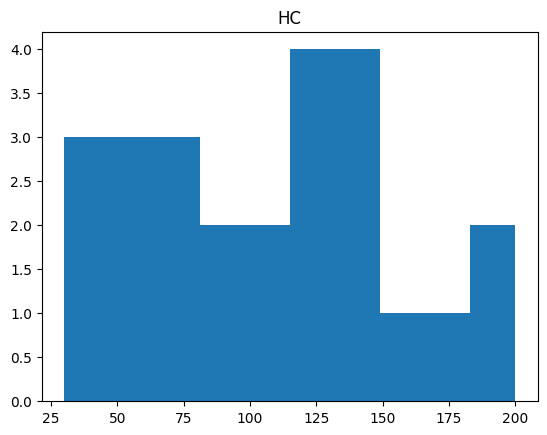

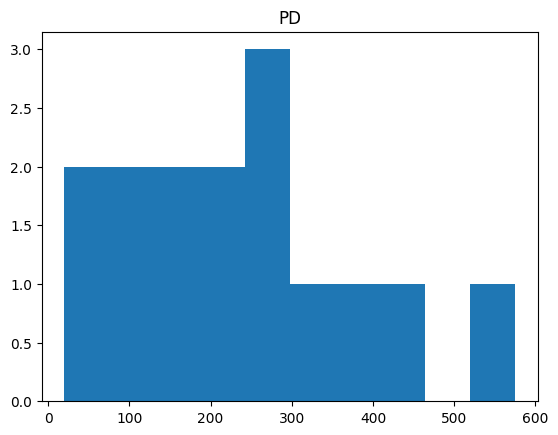

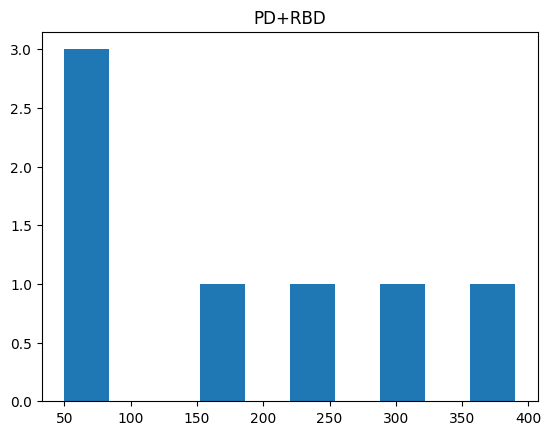

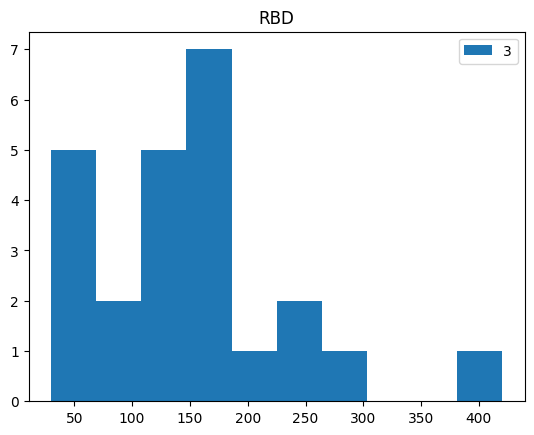

In [31]:
for key in length_dists.keys():
    plt.figure()
    plt.title(class_label_dict[key])
    plt.hist(length_dists[key], label = key ) 
plt.legend()

(array([18., 15., 20.,  6.,  5.,  2.,  2.,  2.,  0.,  1.]),
 array([ 20. ,  75.5, 131. , 186.5, 242. , 297.5, 353. , 408.5, 464. ,
        519.5, 575. ]),
 <BarContainer object of 10 artists>)

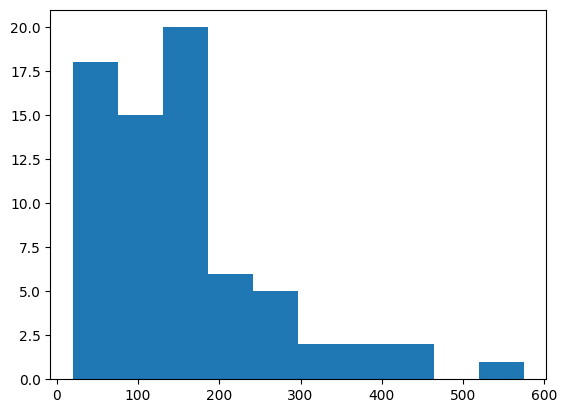

In [26]:
ts_lengths = []
for i in range(71):
    length = len(X.iloc[i,0])
    class_val = y.iloc[i]
    ts_lengths.append(length)
    length_dists[class_val].append(length)
plt.hist(np.array(ts_lengths))

In [116]:
#----------------------- 50 , 0 subs  

#----------------------------------------- 80,90,95,99 1 sub , [:50]

#--------------------------------------------------------------- 100,125,145,149, 2 sub [:50] , [50:100]
#--------------------------------------------------------------------------- 125 , 2 sub, [:50] , [50:100]  
#------------------------------------------------------------------------------------------------------------150, 3 sub [:50] , [50:100] , [100:150]

#### Creating more samples from existing samples

In [59]:
# IMHO ---> Divide by 50 - 0.5 & round down --> This determines how many subsequences we will have from the original TS
def generate_subsamples(original_ts, sub_length = 80):
    div_num = len(original_ts) / sub_length

    if div_num < 1.6 : 
        num_subs = 0 
    else:
        num_subs = math.floor(div_num)
        
    #initialise subsequences list 
    subs_list = []
    subs_list.append(original_ts)
    
    for i in range(1, num_subs+1):
        start_idx = (i-1)*sub_length
        end_idx = start_idx + sub_length
        
        subsequence = original_ts[start_idx : end_idx]
        subs_list.append(subsequence)   
        
    return subs_list

In [60]:
t1 = time.time()
new_df_dict = {}

for col in X_bpw.columns:
    
    X_subset = pd.DataFrame(X_bpw.loc[:,col])
    ts_vals = []

    y_vals = []
    group_vals = []
    
    for i in range(len(X_subset)):
        ts = X_subset.iloc[i,0]
        generated_ts =generate_subsamples(ts) 
        ts_vals+= generated_ts
        
        y_vals+=[y.iloc[i] for j in range(len(generated_ts))]
        group_vals+=[groups.iloc[i] for j in range(len(generated_ts))]
    

    new_df_dict[col] = ts_vals 

t2 = time.time()
t2-t1

0.47043895721435547

In [61]:
new_X = pd.DataFrame(new_df_dict)
new_y = np.array(y_vals)
new_groups = np.array(group_vals)

#### Use generated samples data to generate TS Fresh features X

In [65]:
# new_X, new_y, new_groups 
# 1. Convert to TS_Fresh format Dataframe 
ts_fresh_df = format_eeg_data.convert_sktime_df_to_ts_fresh_format(new_X, ts_cols = list(new_X.columns))

# 2. Extract TS_Fresh Features from the dataframe
settings = MinimalFCParameters()

extracted_ts_fresh_df = extract_features(ts_fresh_df, column_id = 'id' , column_sort = 'time', default_fc_parameters=settings)

# 3. Asign extract_ts_fresh_df to the variable X
X = extracted_ts_fresh_df.copy()
#Drop columns where all values are NA 
X = X.dropna(axis = 1)

#Drop columns where all values are the same
# Find columns where all values are the same
same_value_columns = X.columns[X.nunique() == 1]
# Drop columns with the same values
X = X.drop(columns=same_value_columns)

#Generate a region to features dictionary - this will enable us to run expts regionally as before
regional_features_dict = {}
region_channel_dict = constants.region_to_channel_dict
regions = list(region_channel_dict.keys())
for region in regions:
    region_features = [col for col in X.columns if region + '_' in col]
    if len(region_features) > 0 : 
            regional_features_dict[region] = region_features

26-Oct-23 13:59:28 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 120/120 [00:03<00:00, 30.42it/s]


#### Run Experiments

In [40]:
pd.Series(new_groups)

0      1101
1      1101
2      1101
3      1102
4      1102
       ... 
241    3304
242    3304
243    3304
244    3305
245    3306
Length: 246, dtype: object

In [50]:
165*0.8

132.0

In [74]:
t1 = time.time()

X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(X, pd.Series(new_y) , pd.Series(new_groups) , 2)

results_df = run_expts.run_mv_tsc(X_expt,y_expt,groups_expt,{'RF_200' : RandomForestClassifier(n_estimators=200)}, return_df = True , subset_names_and_cols = regional_features_dict, random_states = [1,2])

t2 = time.time()
t2-t1

26.488709449768066

In [44]:
t2 - t1

1.0975430011749268

In [69]:
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
mean_acc_df

,Prefrontal_RF_acc,Frontal_RF_acc,Left Frontal_RF_acc,Right Frontal_RF_acc,Central_RF_acc,Left Central_RF_acc,Right Central_RF_acc,Left Temporal_RF_acc,Right Temporal_RF_acc,Parietal_RF_acc,Left Parietal_RF_acc,Right Parietal_RF_acc,Occipital_RF_acc
0,0.635065,0.550216,0.573377,0.504113,0.600433,0.534848,0.511688,0.459307,0.469697,0.53658,0.448268,0.489177,0.554545


In [71]:
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
mean_acc_df

,Prefrontal_RF_40_acc,Frontal_RF_40_acc,Left Frontal_RF_40_acc,Right Frontal_RF_40_acc,Central_RF_40_acc,Left Central_RF_40_acc,Right Central_RF_40_acc,Left Temporal_RF_40_acc,Right Temporal_RF_40_acc,Parietal_RF_40_acc,Left Parietal_RF_40_acc,Right Parietal_RF_40_acc,Occipital_RF_40_acc
0,0.616667,0.587662,0.610606,0.52316,0.611039,0.531385,0.503247,0.478355,0.432684,0.518831,0.457792,0.466017,0.550216


In [73]:
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
mean_acc_df

,Prefrontal_RF_20_acc,Frontal_RF_20_acc,Left Frontal_RF_20_acc,Right Frontal_RF_20_acc,Central_RF_20_acc,Left Central_RF_20_acc,Right Central_RF_20_acc,Left Temporal_RF_20_acc,Right Temporal_RF_20_acc,Parietal_RF_20_acc,Left Parietal_RF_20_acc,Right Parietal_RF_20_acc,Occipital_RF_20_acc
0,0.603247,0.531818,0.614286,0.468398,0.583333,0.474675,0.47013,0.441558,0.4329,0.522294,0.476623,0.49329,0.578139


In [75]:
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
mean_acc_df

,Prefrontal_RF_200_acc,Frontal_RF_200_acc,Left Frontal_RF_200_acc,Right Frontal_RF_200_acc,Central_RF_200_acc,Left Central_RF_200_acc,Right Central_RF_200_acc,Left Temporal_RF_200_acc,Right Temporal_RF_200_acc,Parietal_RF_200_acc,Left Parietal_RF_200_acc,Right Parietal_RF_200_acc,Occipital_RF_200_acc
0,0.625541,0.568831,0.548918,0.504329,0.591775,0.535281,0.5171,0.519913,0.460173,0.507792,0.4671,0.52619,0.583117


In [45]:
res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
mean_acc_df

,Prefrontal_DT_acc,Frontal_DT_acc,Left Frontal_DT_acc,Right Frontal_DT_acc,Central_DT_acc,Left Central_DT_acc,Right Central_DT_acc,Left Temporal_DT_acc,Right Temporal_DT_acc,Parietal_DT_acc,Left Parietal_DT_acc,Right Parietal_DT_acc,Occipital_DT_acc
0,0.557576,0.527273,0.530303,0.415152,0.60303,0.506061,0.481818,0.49697,0.39697,0.563636,0.548485,0.554545,0.484848


In [43]:
results_df

,random_state,y_true,Prefrontal_DT_y_preds,Frontal_DT_y_preds,Left Frontal_DT_y_preds,Right Frontal_DT_y_preds,Central_DT_y_preds,Left Central_DT_y_preds,Right Central_DT_y_preds,Left Temporal_DT_y_preds,Right Temporal_DT_y_preds,Parietal_DT_y_preds,Left Parietal_DT_y_preds,Right Parietal_DT_y_preds,Occipital_DT_y_preds
0,1,"[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,...","[[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,...","[[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,...","[[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,...","[[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,...","[[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,...","[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,...","[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,..."
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","[[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,...","[[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,...","[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,...","[[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,...","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,...","[[1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,...","[[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,...","[[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,...","[[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,..."
